<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

## Utilities

In [24]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Get the Dataset

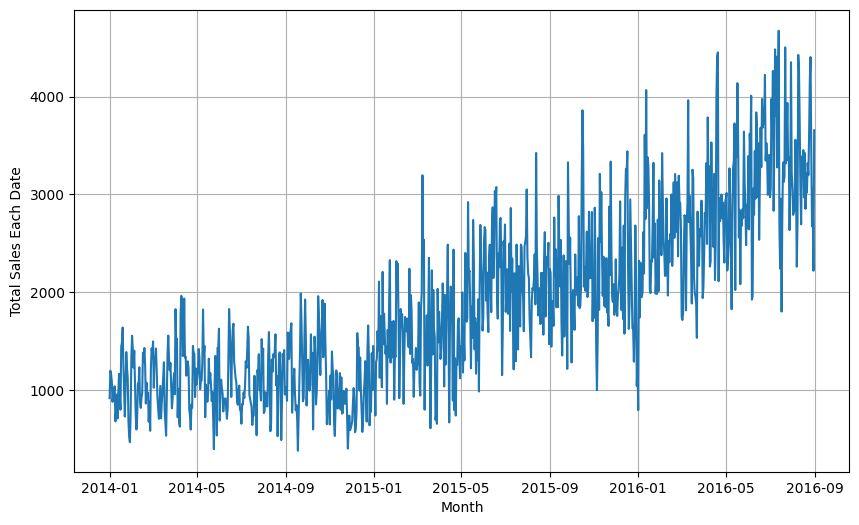

In [25]:
# Initialize lists
dates = []
sales = []

# Open CSV file
with open('../Dataset/sales_data_processed.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sales number to lists
  for row in reader:
      # Parse date and append
      dates.append(datetime.strptime(row[0], '%Y-%m-%d'))
      sales.append(float(row[1]))

# Convert lists to numpy arrays
time = np.array(dates)
series = np.array(sales)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Total Sales Each Date')

In [8]:
# Define the split time
ROW_COUNT = len(series)

print(f"Number of rows (excluding header): {ROW_COUNT}")


Number of rows (excluding header): 974


## Split the Dataset

In [9]:
# Define the split time
SPLIT_TIME = int(0.7 * ROW_COUNT)

# Get the train set
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

# Get the validation set
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [10]:
print(f"x_train shape: {x_train.shape}")
print(f"x_valid shape: {x_valid.shape}")

x_train shape: (681,)
x_valid shape: (293,)


## Prepare Features and Labels

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.repeat(10)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [12]:
# Parameters
WINDOW_SIZE = 7
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

# Generate the dataset windows
train_set = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

## Build the Model

In [13]:
from tensorflow.keras.layers import Conv1D, Dense, LSTM
from tensorflow.keras.regularizers import l2

# Build the Model
model = tf.keras.models.Sequential([
    Conv1D(
        filters=16, 
        kernel_size=3, 
        activation="relu", 
        padding='causal', 
        input_shape=[WINDOW_SIZE, 1], 
        kernel_regularizer=l2(0.001)
        ),
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, return_sequences=False, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 16)             64        
                                                                 
 lstm (LSTM)                 (None, 7, 64)             20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33889 (132.38 KB)
Trainable params: 33889 

## Train the Model

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [15]:
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [16]:
history = model.fit(train_set, epochs=1000)

Epoch 1/1000
211/211 [==============================] - 3s 4ms/step - loss: 578.0903 - mae: 578.5887
Epoch 2/1000
211/211 [==============================] - 1s 4ms/step - loss: 367.1539 - mae: 367.6523
Epoch 3/1000
211/211 [==============================] - 1s 4ms/step - loss: 354.9106 - mae: 355.4089
Epoch 4/1000
211/211 [==============================] - 1s 4ms/step - loss: 349.5759 - mae: 350.0742
Epoch 5/1000
211/211 [==============================] - 1s 4ms/step - loss: 350.7539 - mae: 351.2518
Epoch 6/1000
211/211 [==============================] - 1s 4ms/step - loss: 353.1411 - mae: 353.6392
Epoch 7/1000
211/211 [==============================] - 1s 4ms/step - loss: 341.3711 - mae: 341.8691
Epoch 8/1000
211/211 [==============================] - 1s 4ms/step - loss: 342.2068 - mae: 342.7050
Epoch 9/1000
211/211 [==============================] - 1s 4ms/step - loss: 327.7617 - mae: 328.2601
Epoch 10/1000
211/211 [==============================] - 1s 4ms/step - loss: 316.2589 - mae

You can visualize the training and see if the loss and MAE are still trending down.

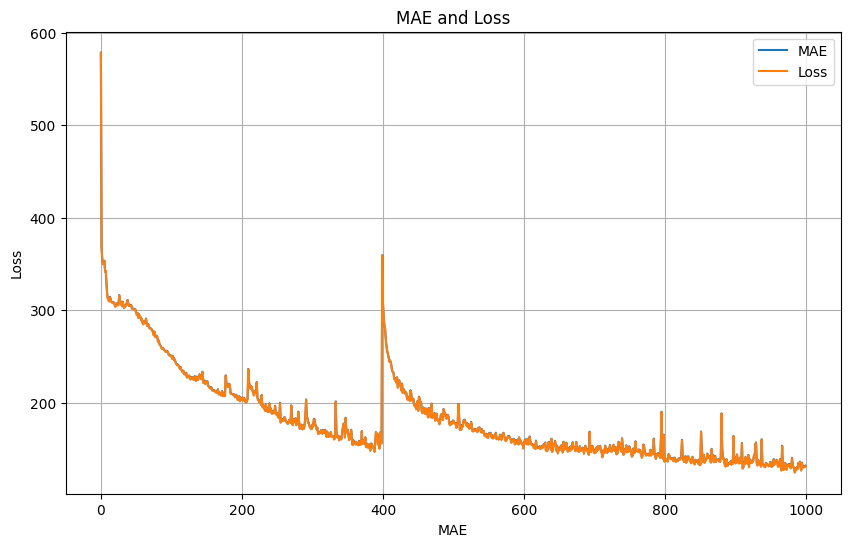

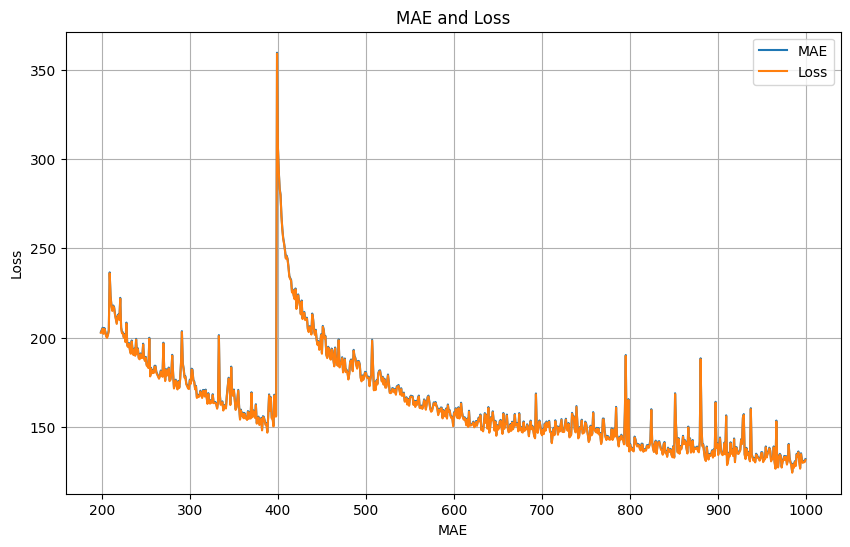

In [26]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [27]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

10/10 [==============================] - 0s 3ms/step


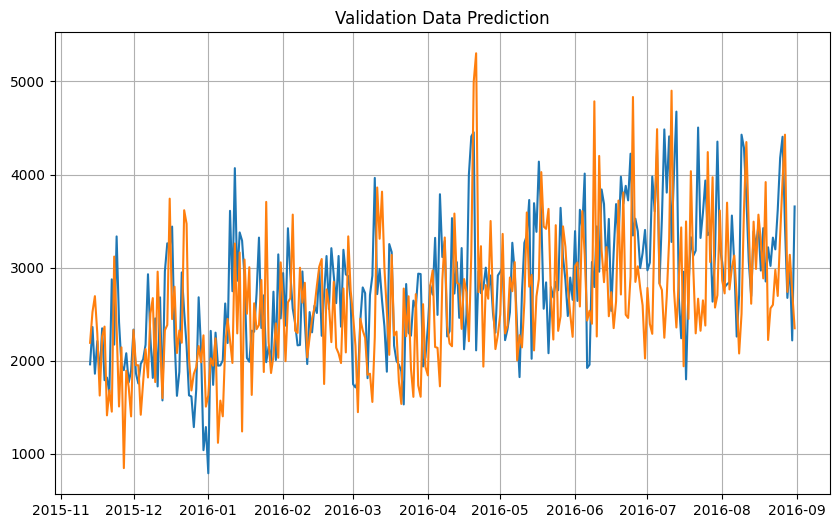

In [31]:
# Show the validation data time series with its prediction

# Reduce the original series
forecast_series = series[SPLIT_TIME - WINDOW_SIZE: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), title="Validation Data Prediction")

31/31 [==============================] - 0s 4ms/step


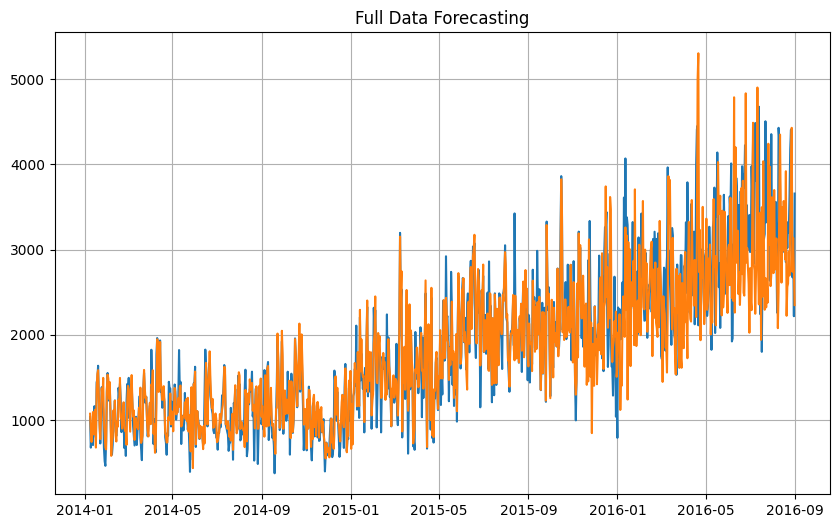

In [32]:
# Show the full time series with its prediction

# Reduce the original series
forecast_series = series[:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# print(time.shape)
# print(series.shape)
# print(results.shape)

# Plot the results
plot_series(time[WINDOW_SIZE:], (series[WINDOW_SIZE:], results), title="Full Data Forecasting")

In [33]:
model.save("../ModelResult/sales_data.h5")

/home/faqih/Bangkit/FinTrack- BangkitCapstone2024/capstone_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
